# Part 2: Data Exploration

## Introduction
In our second entry in this series, we will be visualizing the data that we created last time. Here, we will try to identify trends in the data to hopefully inform us on how to set up our clustering algorithm. We will also predict the missing gender values using another algorithm so that we can increase the accuracy of our clustering algorithm, which we will be working on in Part 3.

In [46]:
import pandas as pd
import numpy as np
import plotly.express as px

## Reading Datasets

In [2]:
df = pd.read_csv('../data/dataset.csv')

In [3]:
df.head()

,profile,gender,Comedy,Action,Fantasy,Adventure,Drama,Sci-Fi,Kids,Shounen,...,Police,Samurai,Vampire,Cars,Thriller,Josei,Shounen Ai,Shoujo Ai,Yaoi,Yuri
0,-----noname-----,NaN,3.0,3.0,1.0,2.0,3.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,---SnowFlake---,NaN,1.0,3.0,1.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,--Mizu--,Female,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--Sunclaudius,Male,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,--animeislife--,Female,2.0,6.0,2.0,1.0,4.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
animes = pd.read_csv('../data/animes_clean.csv')

In [5]:
animes = animes.drop('genre', axis=1)

## What is Available vs. What People Watch
Let's visualize the genres that users have favorited. We will use a bar chart to get an overview of user preferences.

In [6]:
user_genre_sum = df.drop(['profile', 'gender'], axis=1).sum()
fig = px.bar(user_genre_sum, title='Cumulative Sum of Genres for All Users')
fig.show()

Right now it is rather difficult to see any trends in the data, which are obscured by the large range of favorites in each genre. However, if we look at the user favorites distribution against the dstribution of anime genres, we can start to see some interesting trends.

In [7]:
anime_genre_sum = animes.drop(['uid', 'title', 'episodes', 'members', 'score'], axis=1).sum()
fig = px.bar(anime_genre_sum, title='Cumulative Sum of All Anime Genres')
fig.show()

It stands to reason that if a genre is present in a large number of shows on the market, then users will favorite that particular genre more often than others. For example, we can see that over 5000 shows have 'comedy' as one of their genres, so it is no surprise that alot of users also have comedy in their favorites. What is interesting is when we look at shows that have much smaller market shares. In particular, 'thrillers', 'psychological', and 'mystery'. 'Thrillers' only occupy a small fraction of the market with 111 shows in total, yet over 19,000 users have added thrillers to their favorites. 

### Proportion of user favorites in relation to Market Share


We can further highlight the performance of genres by plotting the percentage of a user's favorites for a genre against a genre's market share. Here, the user_favorites is the average percentage of user's favorites containing a certain genre. The market_share is the percentage that a genre shows up for all the shows combined.

In [8]:
user_genre_sum_percent = df.drop(['profile', 'gender'], axis=1).mean() / df.drop(['profile', 'gender'], axis=1).mean().sum(axis=0)

In [9]:
anime_genre_sum_percent = animes.drop(['uid', 'title', 'episodes', 'members', 'score'], axis=1).mean() / animes.drop(['uid', 'title', 'episodes', 'members', 'score'], axis=1).mean().sum(axis=0)

In [10]:
user_v_anime = pd.concat([user_genre_sum_percent, anime_genre_sum_percent], axis=1)
user_v_anime.columns = ['user_favorites', 'market_share']

In [11]:
px.bar(user_v_anime, barmode='group')

If we were to imagine that there were a grand total of 1000 genres across some number of shows, and there was a total of 1000 genre favorites for some number of users, we look at how often users favorite a genre in relation to its market share. If their fractions are equal, then that would mean that people favorite a genre about as often as there are shows that have this genre. If users are favoriting a genre more often than its market share, that would indicate that this particular genre is popular among users. The other end of the spectrum would be shows that have a smaller user fraction than the market share, that would mean that in general users do not like this genre. However, these 'unpopular' genres could hold interesting information. It is possible that a genre is what is called a niche, in which it caters to a specific audience. In this case these genres would be an important cluster-defining factor.

# Filling in Missing Gender Data
Now, coming back to the point made in the previous post about the missing gender data. Of the roughly 37000 entries about 9700, or a quarter, of users have not specified their gender. While it might be fine to simply drop those users when performing the clustering, we can do better. We can use a logistic regression to predict the user's gender in order to produce more accurate clustering.

In [12]:
print('Gender count:')
print(df['gender'].dropna().count())
print('Missing count:')
print(df[df['gender'].isna() == True]['profile'].count())

Gender count:
27739
Missing count:
9724


In [45]:
import matplotlib.pyplot as plt

In [14]:
df['gender'] = df['gender'].fillna('Not Specified')

In [15]:
import plotly

In [16]:
fig = px.pie(df.groupby('gender').count().reset_index(), names='gender', values='profile', color_discrete_sequence=['#636EFA', '#00CC96', '#EF553B'])
fig.show()

We can see that 50.7% of users are male, 22.4% are female, about 1% are non-binary, and 26% are not specified. For simplicity's sake we will only be considering the male and female genders when performing machine learning for this project.

In [17]:
df = df.drop(df[df['gender'] == 'Non-Binary'].index)

### Missing Gender Entries
What to do with users who have not specified their gender? About a quarter of all users have not listed their gender on their profiles. While there are enough data entries to simply throw out data that doesn't have gender, it would be quite a waste to do so. Instead, these gender values could be predicted using a logistic regression.

In order to perform logistic regression, we will have to convert the genders into dummy variables.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [19]:
df_gen_pred = df.drop(df[df['gender'] == 'Not Specified'].index)

In [20]:
unk_gen = df[df['gender'] == 'Not Specified']

In [21]:
def gen_dummy(gender):
    if gender == 'Male':
        return 1
    return 0

In [22]:
df_gen_pred['gender'] = df_gen_pred['gender'].apply(gen_dummy)

The next step is to scale the genre counts.

In [23]:
genders = df_gen_pred['gender']
genders

2        0
3        1
4        0
5        1
6        0
        ..
37454    1
37457    1
37459    1
37460    0
37461    1
Name: gender, Length: 27379, dtype: int64

In [24]:
df_gen_pred = df_gen_pred.drop(['profile', 'gender'], axis=1)

Next, we will need to scale the genre count information. We need to do this step because without scaling, the logistic regression will fail to converge.

In [25]:
scaler = StandardScaler()
scaler.fit(df_gen_pred)
gen_pred_scaled = scaler.transform(df_gen_pred)

In [26]:
gen_pred_scaled

array([[-0.37654806, -0.84288072,  0.44617195, ..., -0.15001681,
        -0.04485245, -0.02497316],
       [-1.41502799, -0.3382839 , -0.28552867, ..., -0.15001681,
        -0.04485245, -0.02497316],
       [-0.37654806,  1.68010342,  0.44617195, ..., -0.15001681,
        -0.04485245, -0.02497316],
       ...,
       [-1.41502799, -0.3382839 , -0.28552867, ..., -0.15001681,
        -0.04485245, -0.02497316],
       [-0.37654806,  0.67090976, -1.01722928, ..., -0.15001681,
        -0.04485245, -0.02497316],
       [-1.41502799, -1.34747755, -1.01722928, ..., -0.15001681,
        -0.04485245, -0.02497316]])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(gen_pred_scaled, genders, test_size=0.3, random_state=42)

In [28]:
gen_clf = LogisticRegression(random_state=42)
gen_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [29]:
y_pred = gen_clf.predict(X_train)

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
accuracy_score(y_train, y_pred)

0.7915470910513958

Our logistic regression has an accuracy of about 80%, which is a pretty decent score. We can save this logistic regression using pickle if we ever need to use it again.

In [32]:
import pickle
pickle.dump(gen_clf, open('../models/gender_logreg.pickle', 'wb'))

### Generate values for users with missing gender
Now we will predict the missing gender values and merge the results back into the main dataset.

In [33]:
unk_gen_pred = unk_gen.drop(['profile', 'gender'], axis=1)

In [34]:
scaler = StandardScaler()
scaler.fit(unk_gen_pred)
unk_gen_scaled = scaler.transform(unk_gen_pred)

In [35]:
gen_pred = gen_clf.predict(unk_gen_scaled)

In [36]:
unk_gen['gender'] = gen_pred

C:\Users\engwb\AppData\Local\Temp/ipykernel_5800/3009440547.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
unk_gen

,profile,gender,Comedy,Action,Fantasy,Adventure,Drama,Sci-Fi,Kids,Shounen,...,Police,Samurai,Vampire,Cars,Thriller,Josei,Shounen Ai,Shoujo Ai,Yaoi,Yuri
0,-----noname-----,1,3.0,3.0,1.0,2.0,3.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,---SnowFlake---,1,1.0,3.0,1.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,-Ancient,1,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,-Belka,1,4.0,3.0,2.0,1.0,1.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,-Candyz-,1,0.0,2.0,1.0,0.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37452,zygisrko,1,4.0,4.0,1.0,1.0,1.0,2.0,0.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
37455,zylee,1,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37456,zyoxo,1,2.0,3.0,1.0,4.0,1.0,2.0,0.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
37458,zzSorazz,1,3.0,1.0,1.0,1.0,3.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
kno_gen = df.drop(df[df['gender'] == 'Non-Binary'].index)

In [39]:
kno_gen = df.drop(df[df['gender'] == 'Not Specified'].index)

In [40]:
kno_gen['gender'] = kno_gen['gender'].apply(gen_dummy)

## Rejoining users with known gender and users with unknown gender

In [41]:
kno_gen = pd.concat([kno_gen, unk_gen])

In [42]:
kno_gen = kno_gen.rename(columns={'gender': 'male'})

In [43]:
kno_gen

,profile,male,Comedy,Action,Fantasy,Adventure,Drama,Sci-Fi,Kids,Shounen,...,Police,Samurai,Vampire,Cars,Thriller,Josei,Shounen Ai,Shoujo Ai,Yaoi,Yuri
2,--Mizu--,0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--Sunclaudius,1,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,--animeislife--,0,2.0,6.0,2.0,1.0,4.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,--d41,1,3.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,--mimika--,0,4.0,3.0,3.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37452,zygisrko,1,4.0,4.0,1.0,1.0,1.0,2.0,0.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
37455,zylee,1,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37456,zyoxo,1,2.0,3.0,1.0,4.0,1.0,2.0,0.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
37458,zzSorazz,1,3.0,1.0,1.0,1.0,3.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save the updated dataset for future use.

In [44]:
kno_gen.to_csv('../data/final_dataset.csv', index=False)
# pickle.dump(kno_gen, open('../data/dataset_gender.pickle', 'wb'))

# Breakdown of updated genders
With the unknown gender values filled out, let's take a look at the gender distribution again.

In [5]:
final_df = pd.read_csv('../data/final_dataset.csv')

In [4]:
fig = px.pie(final_df.groupby('male').count().reset_index(), names='male', values='profile')
fig.show()

# Differences between genders
Are there any differences to preference by gender? Many genres are targeted specifically towards a gender group, so we can expect to have at least some differences. For genres that appeal to both genders we should expect to see that the difference should be minimal.

In [48]:
male_genre_sum_percent = kno_gen[kno_gen['male'] == 1].drop(['profile', 'male'], axis=1).mean() / kno_gen.drop(['profile', 'male'], axis=1).mean().sum(axis=0)

In [49]:
female_genre_sum_percent = kno_gen[kno_gen['male'] == 0].drop(['profile', 'male'], axis=1).mean() / kno_gen.drop(['profile', 'male'], axis=1).mean().sum(axis=0)

In [50]:
gender_genre_sum_percent = pd.DataFrame(male_genre_sum_percent).T
gender_genre_sum_percent = gender_genre_sum_percent.append(pd.DataFrame(female_genre_sum_percent).T)

In [51]:
gender_genre_sum_percent['gender'] = ['male', 'female']

In [52]:
gender_genre_sum_percent = gender_genre_sum_percent.reset_index().drop('index', axis=1).set_index('gender')

In [53]:
gender_genre_sum_percent = gender_genre_sum_percent.T

In [54]:
gender_genre_melt = pd.melt(gender_genre_sum_percent)

In [55]:
px.bar(gender_genre_sum_percent.apply(lambda x: x / anime_genre_sum_percent), barmode='group')

## Choosing How many clusterings are present
In order to do unsupervised learning, we will need to figure out how many groupings are present in the data. For starters, there must be at least 2 since gender plays a large role as evidenced by the accuracy of the logistic regression. For females, animes listed under female demographics like shoujo, josei, etc. are evidently more favorited than males. As for males, genres that can be attributed to male preferences like sci-fi, space, cars, and others. Considering all this and time constraints for this presentation, I chose 4 for the number of clusters. For each of the genders, there are at least 2 distinct groupings which we will examine individually.

## Clustering with Hierarchical Clustering
The clustering algorithm I chose was hierarchical clustering. I chose hierarchical clustering since the list of genres also includes themes and demographics, which can have a tree like structure. For example, space and mecha are both related to sci-fi. There is a relationship between the different genres that we will be using to determine groupings of users.

In [44]:
from sklearn.cluster import AgglomerativeClustering

In [7]:
cluster_train = final_df.copy()

In [8]:
cluster_train.drop('profile', axis=1, inplace=True)

In [9]:
cluster_train_cols = cluster_train.columns

Use standardscaler to scale data before clustering, since it uses a distance metric. Users with lots of favorites would be very different from users with few favorites otherwise.

In [10]:
scaler = StandardScaler()
scaler.fit(cluster_train)
cluster_train = pd.DataFrame(scaler.transform(cluster_train), columns=cluster_train_cols)

In [11]:
cluster_train.dropna(inplace=True)

We will use a dendrogram to find the optimal amount of clusters in the data. A dendrogram is a visualization of hierarchical data. This will allow us to visually inspect the branching of the data in order to choose the best amount of clusters.

In [43]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

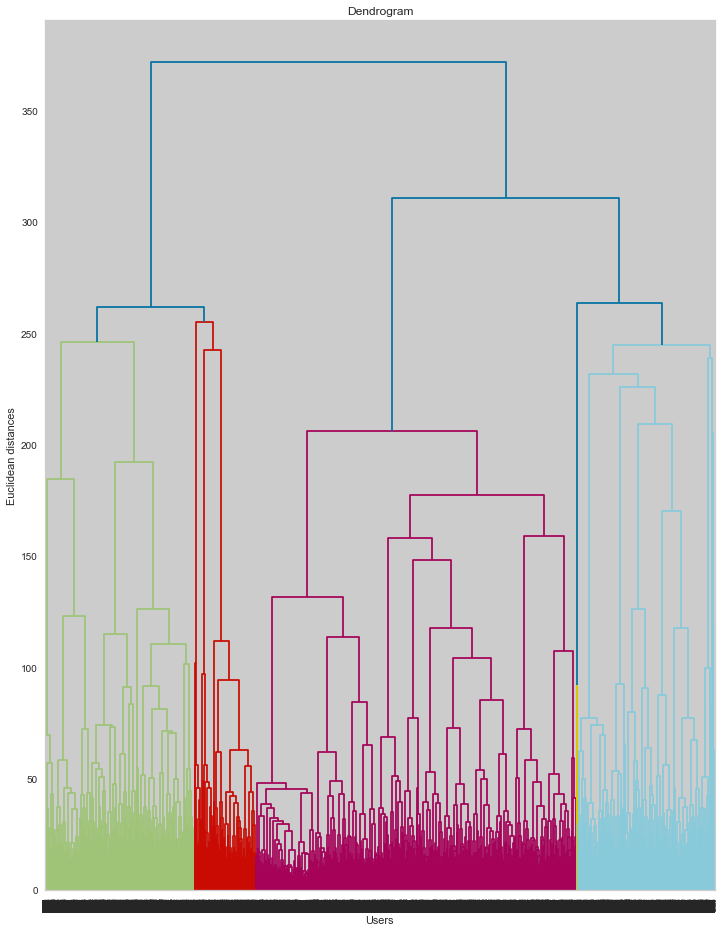

In [49]:
plt.figure(figsize=(12, 16))
plt.title('Dendrogram')
plt.xlabel('Users')
plt.ylabel('Euclidean distances')
dendrogram = sch.dendrogram(sch.linkage(cluster_train, method  = "ward"))
plt.show()

There isn't a statistical technique that will allow us to determine the number of clusters in hierarchical clustering, like k-means with its elbow method. We can use the dendrogram to look for distinct groupings of users, which are characterized by densely branching sections of the dendrogram. This dendrogram actually shows us how many major groups of users are present, characterized as different colors. If we look at around the 260 mark of the distance measure, we can see that if we cut a horizontal line across the dendrogram we will get 5 clusters.

In [18]:
agg_clf = AgglomerativeClustering(n_clusters=5)
y_pred = agg_clf.fit(cluster_train)

In [19]:
y_pred.labels_

array([4, 2, 4, ..., 0, 2, 1], dtype=int64)

In [25]:
final_df['group'] = y_pred.labels_

In [26]:
final_df

,profile,male,Comedy,Action,Fantasy,Adventure,Drama,Sci-Fi,Kids,Shounen,...,Samurai,Vampire,Cars,Thriller,Josei,Shounen Ai,Shoujo Ai,Yaoi,Yuri,group
0,--Mizu--,0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,--Sunclaudius,1,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,--animeislife--,0,2.0,6.0,2.0,1.0,4.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,--d41,1,3.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4
4,--mimika--,0,4.0,3.0,3.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37098,zygisrko,1,4.0,4.0,1.0,1.0,1.0,2.0,0.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
37099,zylee,1,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
37100,zyoxo,1,2.0,3.0,1.0,4.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
37101,zzSorazz,1,3.0,1.0,1.0,1.0,3.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [27]:
def dummy_to_gender(male):
    if male == 1:
        return 'Male'
    else:
        return 'Female'

In [28]:
final_df['male'] = final_df['male'].apply(dummy_to_gender)

In [29]:
final_df.to_csv('../data/clustered_df.csv', index=False)

Now we have classified all of our users based on our five groupings. In the next and final blog post, we will be analyzing the groupings and discuss potential ideas for utilizing this clustered data.